In [1]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pandas as pd
import os
import sys
import seaborn as sns
sys.path.insert(0, 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/Pedophysics_code')
sys.path.insert(0, 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/Pedophysics_code')

from pedophysics import predict, Soil
from statistics import mode
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root
from scipy.stats import spearmanr

# Geospatial data manipulation and raster operations
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline

from shapely.geometry import Point

# Electromagnetic induction data inversion package
from emagpy import Problem
from plots import *
from PM import *
import sys
%matplotlib inline

pd.set_option('display.max_columns', None)
from utils.spatial_utils import utm_to_epsg, get_coincident


# Configure input

In [2]:
# User input
config = {}
s_site = 'P'; # P = Proefhoeve; M = Middelkerke
# Define input datatype and source folder
datafolder = 'Data' # data folder
em_intype = 'reca'   # 'reca' = rECa EMI data; 'lin' = LIN ECa EMI data; 
cal = 'calibrated' # 'non_calibrated'
config['instrument_code'] = 'Dualem-21HS'

## Load data

In [3]:
if s_site == 'P':
    profile_prefix = 'proefhoeve'
    if config['instrument_code'] == 'Dualem-21HS':
        emfile_prefix = 'proefhoeve_21HS'
    else: 
        emfile_prefix = 'proefhoeve_421S'
else:
    profile_prefix = 'middelkerke'
    emfile_prefix = 'middelkerke_421S'
    # check if correct instrument (only 421S data available for Middelkerke)
    if config['instrument_code'] == 'Dualem-21HS':
        config['instrument_code'] = 'Dualem-421S'

cal_folder = os.path.join(datafolder, 'calibrated')
em_survey = os.path.join(cal_folder, f'{emfile_prefix}_{cal}_{em_intype}.csv')
samplocs = os.path.join(datafolder, f'{profile_prefix}_samps.csv')
inv_s = os.path.join(datafolder, f'{profile_prefix}_inverted_samples_21HS.csv')

# Profile smoothing parameters 
window_size = 1 # Define your window size for simple moving average filter (1 = no filtering)

# 1.0 Data import and structuring into dataframe
em_survey = pd.read_csv(em_survey, sep=',', header=0)
inverted = pd.read_csv(inv_s, sep=',', header=0)
samples = pd.read_csv(samplocs, sep=',', header=0)
em_samples = get_coincident(em_survey, samples)

# Data Analysis
### Data wrangling

In [4]:
ds_c = em_samples.copy()
# Caclculate Bulk EC from HydraProbe data at 50Mhz
offset = 4
water_perm = 80
ds_c['bulk_ec_hp'] = logsdon(50e6, ds_c.rperm, ds_c.iperm)

ds_c['bulk_ec_dc_hp'] = predict.BulkECDC(Soil(frequency_ec = 50e6,
                                              bulk_ec = ds_c.bulk_ec_hp.values))

ds_c['bulk_ec_tc_hp'] = SheetsHendrickxEC( ds_c.bulk_ec_hp, ds_c.temp)
ds_c['bulk_ec_dc_tc_hp'] = predict.BulkECDCTC(Soil(temperature = ds_c.temp.values,
                                                    bulk_ec_dc = ds_c.bulk_ec_dc_hp.values
                                                    ))

# Caclculate Water EC from HydraProbe data at 50Mhz
ds_c['water_ec_hp'] = Hilhorst(ds_c.bulk_ec_hp, ds_c.rperm, water_perm, offset)
ds_c['water_ec_hp_t'] = WraithOr(ds_c.water_ec_hp, ds_c.temp)
ds_c['iperm_water_t'] = ds_c.water_ec_hp_t/(50e6*2*pi*epsilon_0)

In [5]:
inv_columns = inverted.columns[3:-1]
ds_c[inv_columns] = np.nan

for idc, c in enumerate(inv_columns):

    for i in range(len(inverted.x)):
        ds_c.loc[ds_c.code == i+1, c] = inverted.loc[i, c]

def closest_ec(row):
    depth = row['depth']
    # Filter columns that start with 'EC_' but not 'EC_end'
    ec_cols = [col for col in row.index if col.startswith('EC_') and col != 'EC_end']
    # Convert the part after 'EC_' to float and calculate the absolute difference with depth
    differences = {col: abs(depth/100 - float(col.split('_')[1])) for col in ec_cols}
    # Find the column name with the minimum difference
    closest_col = min(differences, key=differences.get)
    return row[closest_col]

# Apply the function to each row
ds_c['bulk_ec_inv'] = ds_c.apply(closest_ec, axis=1)

ds_c['bulk_ec_dc_tc_inv'] = predict.BulkECDCTC(Soil(temperature = ds_c.temp.values+273.15,
                                                      frequency_ec = 9e3,
                                                      bulk_ec = ds_c.bulk_ec_inv.values/1000))*1000

ds_c.to_csv('ds_c.csv')
#print(ds_c)

### Correlations

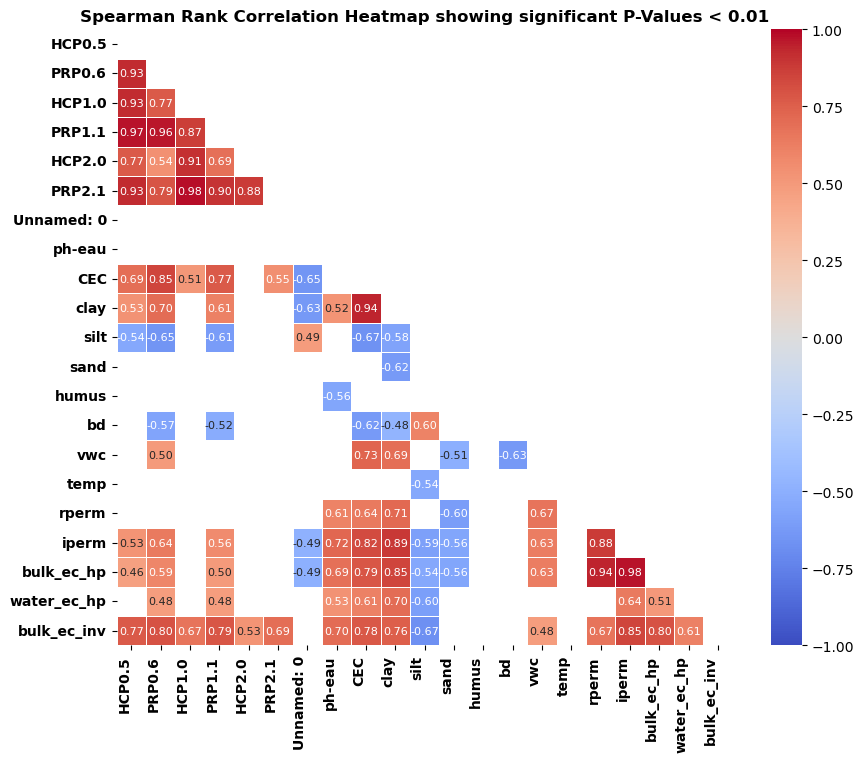

In [6]:
filtered_features = ['x', 'y', 'z', 't', 'geometry', 'code', 'TOC', 'x_clhs', 'y_clhs', 'depth', 'copeky', 'bulk_ec_dc_hp', 'bulk_ec_tc_hp', 'bulk_ec_dc_tc_hp', 'water_ec_hp_t', 'iperm_water_t', 'bulk_ec_dc_tc_inv']

# Filter out columns that start with 'EC_' and are not constant
non_ec_columns = [col for col in ds_c.columns if col not in filtered_features and not col.startswith('EC_') and not col.endswith('_inph')]

# Calculate the Spearman rank correlation coefficients and p-values
corr, p_value = spearmanr(ds_c[non_ec_columns], nan_policy='omit')

# Convert to DataFrame for easier plotting
corr_df = pd.DataFrame(corr, index=non_ec_columns, columns=non_ec_columns)
p_value_df = pd.DataFrame(p_value, index=non_ec_columns, columns=non_ec_columns)

# Create a mask for significant p-values (e.g., p < 0.01)
p_value_mask = 0.01
significant_mask = p_value_df < p_value_mask

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Combine the masks
final_mask = mask | ~significant_mask

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=final_mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, vmin=-1, vmax=1, annot_kws={"size": 8})

# Adjust layout for better readability
plt.xticks(rotation=90, ha='right', fontsize=10, fontweight='bold')
plt.yticks(rotation=0, fontsize=10, fontweight='bold')
plt.title('Spearman Rank Correlation Heatmap showing significant P-Values < '+str(p_value_mask), fontsize=12, fontweight='bold')

# Show the plot
plt.show()


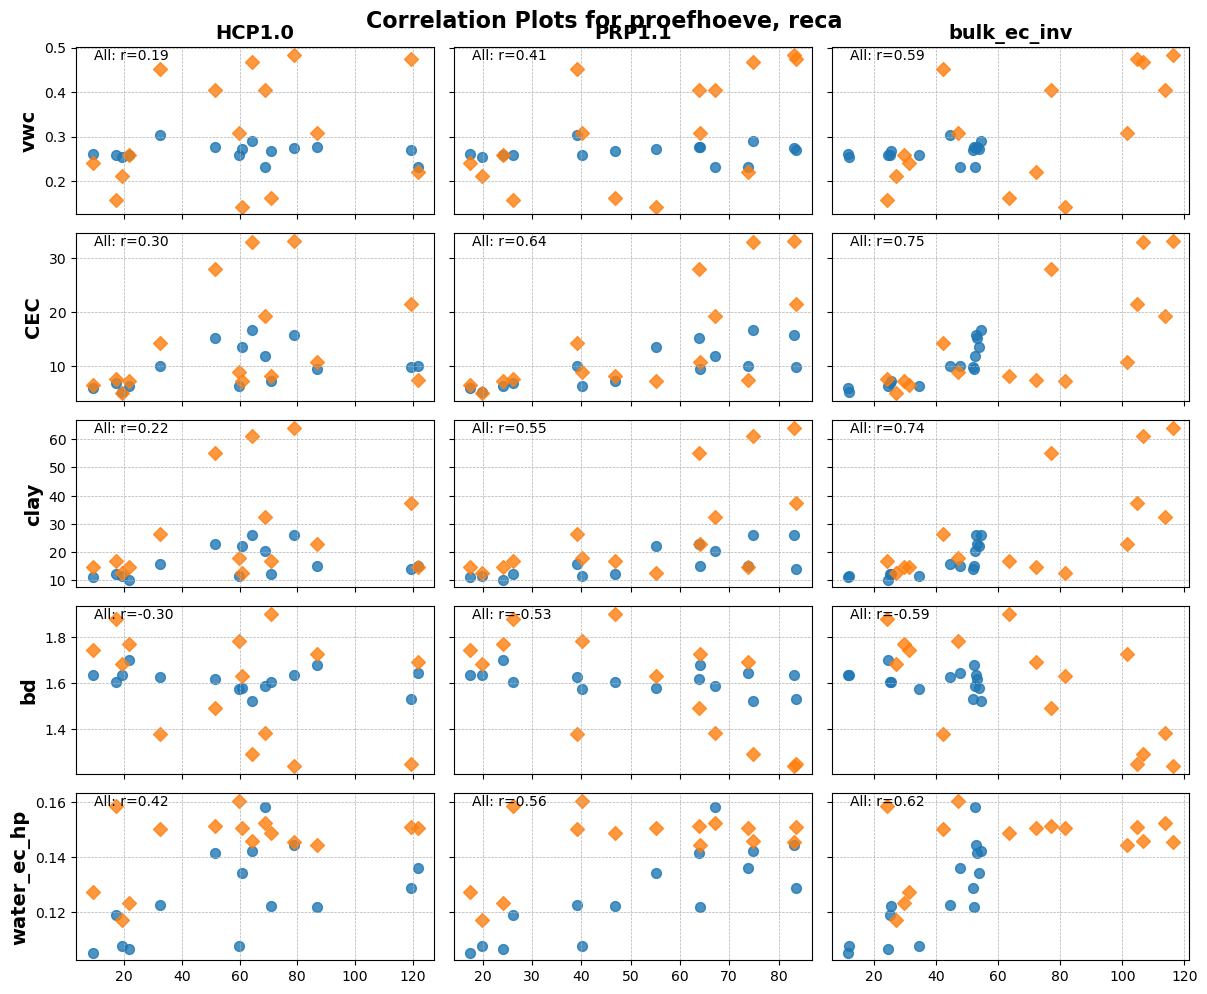

In [7]:
fig, axes = plt.subplots(5, 3, figsize=(12, 10))
ss = 50  # Reduced size for scatter points

targets = ['vwc', 'CEC', 'clay', 'bd', 'water_ec_hp']
preds = ['HCP1.0', 'PRP1.1', 'bulk_ec_inv']

def corr_plot(df, preds, targets):
    for target_index, target in enumerate(targets):
        for pred_index, pred in enumerate(preds):
            ax = axes[target_index, pred_index]
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            
            # General correlation coefficient
            general_corr = np.corrcoef(df[pred].dropna(), df[target].dropna())[0, 1]
            ax.text(0.05, 0.95, f'All: r={general_corr:.2f}', transform=ax.transAxes, va="center")

            for layer_cm in [10, 50]:
                x_data = df[df['depth'] == layer_cm][pred]
                y_data = df[df['depth'] == layer_cm][target]
                
                if layer_cm == 10:
                    ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='o')
                if layer_cm == 50:
                    ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='D')

            if target_index == 0:
                ax.set_title(pred, fontweight='bold', fontsize=14)
            if target_index != len(targets) - 1:
                ax.set_xticklabels([])

            if pred_index == 0:
                ax.set_ylabel(target, fontweight='bold', fontsize=14)
            if pred_index != 0:
                ax.set_yticklabels([])

corr_plot(ds_c, preds, targets)
plt.suptitle(f"Correlation Plots for {profile_prefix}, {em_intype}", fontweight='bold', fontsize=16)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

# Deterministic modelling

## Implementation

In [8]:
clay_50cm = np.mean(ds_c.clay[ds_c['depth']==50])
clay_10cm = np.mean(ds_c.clay[ds_c['depth']==10])
bd_50cm = np.mean(ds_c.bd[ds_c['depth']==50])
bd_10cm = np.mean(ds_c.bd[ds_c['depth']==10])
water_ec_hp_50cm = np.mean(ds_c.water_ec_hp[ds_c['depth']==50])
water_ec_hp_10cm = np.mean(ds_c.water_ec_hp[ds_c['depth']==10])
water_ec_hp_50cm_t = np.mean(ds_c.water_ec_hp_t[ds_c['depth']==50])
water_ec_hp_10cm_t = np.mean(ds_c.water_ec_hp_t[ds_c['depth']==10])
clay_mean = np.mean(ds_c.clay)
bd_mean = np.mean(ds_c.bd)
water_ec_hp_mean = np.mean(ds_c.water_ec_hp)
water_ec_hp_mean_t = np.mean(ds_c.water_ec_hp_t)
temp_50cm = np.mean(ds_c.temp[ds_c['depth']==50])
temp_10cm = np.mean(ds_c.temp[ds_c['depth']==10])
temp_mean = np.mean(ds_c.temp)
vwc_50cm = np.mean(ds_c.vwc[ds_c['depth']==50])
vwc_10cm = np.mean(ds_c.vwc[ds_c['depth']==10])
vwc_mean = np.mean(ds_c.vwc)

feature_set = [
    'HCP0.5',
    'HCP1.0',
    'HCP2.0',
#    'HCP4.0',
    'PRP0.6',
    'PRP1.1',
    'PRP2.1',
#    'PRP4.1',
    'bulk_ec_inv',
#    'bulk_ec_dc_tc_inv',
#    'bulk_ec_hp',
#    'bulk_ec_dc_tc_hp'
]

In [9]:
def deterministic(feature, target, df, iters=100, round_n=3):
    df.reset_index(drop=True, inplace=True)
    DR2_test_LS, DRMSE_test_LS = [], []
    DR2_test_LT, DRMSE_test_LT = [], []
    DR2_test_ID, DRMSE_test_ID, wat_ID_ = [], [], []
    y_test_ = []

    ### Extract indices for 10 cm and 50 cm layers
    idx_layer_10 = df[df['depth'] == 10].index
    idx_layer_50 = df[df['depth'] == 50].index
    ### Select data at 10 cm depth
    X_layer_10 = df.loc[idx_layer_10, feature].values.reshape(-1, 1)
    Y_layer_10 = df.loc[idx_layer_10, target].values
    ### Select data at 50 cm depth
    X_layer_50 = df.loc[idx_layer_50, feature].values.reshape(-1, 1)
    Y_layer_50 = df.loc[idx_layer_50, target].values

    f_ec = 9000
    t_conv = 273.15
    i=0
    for i in range(iters):
        ### Split data of 10cm layer and keep track of test indices
        X_train10, X_test10, y_train10, y_test10, idx_train10, idx_test10 = train_test_split(X_layer_10, Y_layer_10, idx_layer_10, test_size=0.3, random_state=i)
        ### Split data of 50cm layer and keep track of test indices
        X_train50, X_test50, y_train50, y_test50, idx_train50, idx_test50 = train_test_split(X_layer_50, Y_layer_50, idx_layer_50, test_size=0.3, random_state=i)

        ### Combine test indices from both layers
        idx_test = np.concatenate((idx_test10, idx_test50))
        y_test = np.concatenate((y_test10, y_test50)).flatten()
        X_test = (np.concatenate((X_test10, X_test50))/1000).flatten()
        y_test_.append(y_test)

        ### Predict using layer together 
        LT = Soil( 
                    bulk_ec = X_test,
                    frequency_ec=f_ec,
                    clay = clay_mean,
                    bulk_density = bd_mean,
                    water_ec = water_ec_hp_mean,
                    temperature = temp_mean+t_conv
                      )
        wat_LT = predict.Water(LT)
        DR2_test_LT.append(round(r2_score(y_test, wat_LT), round_n))
        DRMSE_test_LT.append(round(RMSE(y_test, wat_LT), round_n))

        ### Predict using ideal samples
        filtered_df = df.loc[idx_test]
        ID =  Soil( 
                    bulk_ec = X_test,
                    frequency_ec=f_ec,
                    clay = filtered_df['clay'].values,
                    bulk_density = filtered_df['bd'].values,
                    water_ec = filtered_df['water_ec_hp'].values,
                    temperature = filtered_df['temp'].values+t_conv
                      )
        wat_ID = predict.Water(ID)
        wat_ID_.append(wat_ID)
        DR2_test_ID.append(round(r2_score(y_test, wat_ID), round_n))
        DRMSE_test_ID.append(round(RMSE(y_test, wat_ID), round_n))

        ### Predict using 10 cm layer
        layer_10 = Soil( 
                    bulk_ec = X_test10.flatten()/1000,
                    frequency_ec=f_ec,
                    clay = clay_10cm,
                    bulk_density = bd_10cm,
                    water_ec = water_ec_hp_10cm,
                    temperature = temp_10cm+t_conv
                      )
        Dypred_test10 = predict.Water(layer_10)

        ### Predict using 50 cm layer
        layer_50 = Soil( 
                    bulk_ec = X_test50.flatten()/1000,
                    frequency_ec=f_ec,
                    clay = clay_50cm,
                    bulk_density = bd_50cm,
                    water_ec = water_ec_hp_50cm,
                    temperature = temp_50cm+t_conv
                      )
        Dypred_test50 = predict.Water(layer_50)

        ### Stochastic modelling for layers separate. 
        ### This is a combination of both layer's prediction
        Dypred_test_LS = np.concatenate((Dypred_test10, Dypred_test50))
        DR2_test_LS.append(round(r2_score(y_test, Dypred_test_LS), round_n))
        DRMSE_test_LS.append(round(RMSE(y_test, Dypred_test_LS), round_n))
    
    return DR2_test_LT, DRMSE_test_LT, DR2_test_ID, DRMSE_test_ID, DR2_test_LS, DRMSE_test_LS

Dresults = {}
target = 'vwc'

for feature in feature_set:
    DR2_test_LT, DRMSE_test_LT, DR2_test_ID, DRMSE_test_ID, DR2_test_LS, DRMSE_test_LS = deterministic(feature, target, ds_c)
    Dresults[feature] = {
        'LT': {'R2': DR2_test_LT, 'RMSE': DRMSE_test_LT},
        'ID': {'R2': DR2_test_ID, 'RMSE': DRMSE_test_ID},
        'LS': {'R2': DR2_test_LS, 'RMSE': DRMSE_test_LS}
    }

In [10]:
#Dresults

## Process results

In [11]:
# Convert results to DataFrame for easier processing
Dresults_df = pd.DataFrame(Dresults).T.stack().reset_index()
Dresults_df.columns = ['Feature', 'Model', 'Scores']
Dresults_df = Dresults_df.join(pd.DataFrame(Dresults_df.pop('Scores').values.tolist()))

# Calculate median of each list in RMSE and R2 columns
Dresults_df['Median RMSE'] = Dresults_df['RMSE'].apply(lambda x: np.median(x))
Dresults_df['Median R2'] = Dresults_df['R2'].apply(lambda x: np.median(x))

# Create a DataFrame for median scores
median_scores = Dresults_df[['Feature', 'Model', 'Median RMSE', 'Median R2']]

# Find best features based on criteria
error_criteria = 'RMSE'  # Change to 'R2' to select based on R2
if error_criteria == 'RMSE':
    best_features = median_scores.loc[median_scores.groupby('Model')['Median RMSE'].idxmin()]
else:
    best_features = median_scores.loc[median_scores.groupby('Model')['Median R2'].idxmax()]

# Prepare final DataFrame
final_df = pd.DataFrame({
    'Target': target,
    'Best Feature LT': best_features.loc[best_features['Model'] == 'LT', 'Feature'].values[0],
    'R2 LT':           best_features.loc[best_features['Model'] == 'LT', 'Median R2'].values[0],
    'Best Feature ID': best_features.loc[best_features['Model'] == 'ID', 'Feature'].values[0],
    'R2 ID':           best_features.loc[best_features['Model'] == 'ID', 'Median R2'].values[0],
    'Best Feature LS': best_features.loc[best_features['Model'] == 'LS', 'Feature'].values[0],
    'R2 LS':           best_features.loc[best_features['Model'] == 'LS', 'Median R2'].values[0]
}, index=[0])

print(final_df)

  Target Best Feature LT  R2 LT Best Feature ID   R2 ID Best Feature LS  \
0    vwc          PRP0.6 -0.211          PRP0.6 -2.5305          PRP0.6   

    R2 LS  
0 -1.0975  


## Plot results

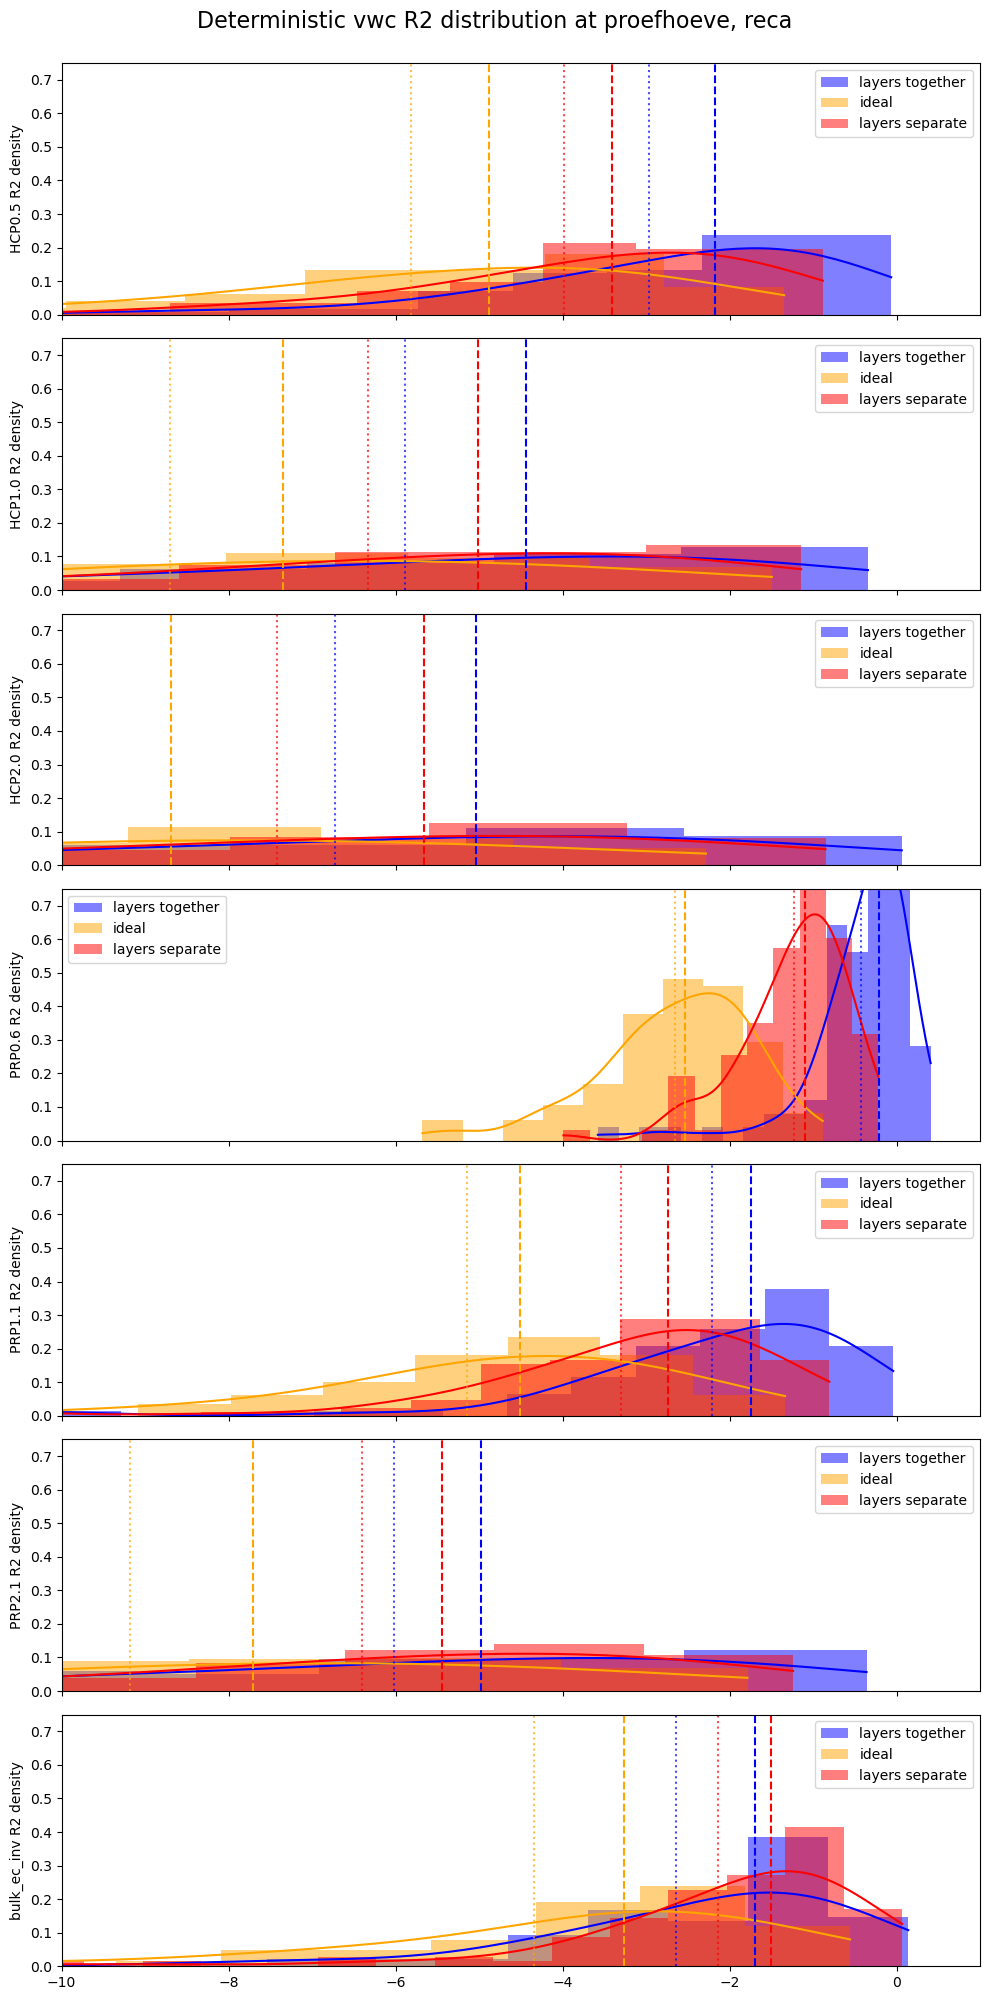

In [12]:
plot_det(Dresults, feature_set, target, profile_prefix, em_intype, s_site, 'R2', 'blue', 'red', 'orange')

# Stochastic modelling

## Implementation

In [13]:
def stochastic(features, target, df, n=4, iters=100, round_n=3):
    ### Defining lists to store results and error indicators
    SR2_train_10_, SR2_test_10_, SRMSE_train_10_, SRMSE_test_10_, Sypred_test_10_ = [], [], [], [], []
    SR2_train_50_, SR2_test_50_, SRMSE_train_50_, SRMSE_test_50_, Sypred_test_50_ = [], [], [], [], []
    SR2_train_LT_, SR2_test_LT_, SRMSE_train_LT_, SRMSE_test_LT_ = [], [], [], []
    SR2_train_LS_, SR2_test_LS_, SRMSE_train_LS_, SRMSE_test_LS_ = [], [], [], []
    y_test_ = []

    ### Extract indices for 10 cm and 50 cm layers
    idx_layer_10 = df[df['depth'] == 10].index
    idx_layer_50 = df[df['depth'] == 50].index
    ### Select data at 10 cm depth
    X_layer_10 = df.loc[idx_layer_10, features].values.reshape(-1, 1)
    Y_layer_10 = df.loc[idx_layer_10, target].values
    ### Select data at 50 cm depth
    X_layer_50 = df.loc[idx_layer_50, features].values.reshape(-1, 1)
    Y_layer_50 = df.loc[idx_layer_50, target].values

    for i in range(iters):
        ### Split data of 10cm layer and keep track of test indices
        X_train10, X_test10, y_train10, y_test10 = train_test_split(X_layer_10, Y_layer_10, test_size=0.3, random_state=i)
        SR2_train_10, SR2_test_10, SRMSE_train_10, SRMSE_test_10, Sypred_test_10 = [], [], [], [], []
        ### Split data of 50cm layer and keep track of test indices
        X_train50, X_test50, y_train50, y_test50 = train_test_split(X_layer_50, Y_layer_50, test_size=0.3, random_state=i)
        SR2_train_50, SR2_test_50, SRMSE_train_50, SRMSE_test_50, Sypred_test_50 = [], [], [], [], []
        ### Combine test indices from both layers
        #idx_test = np.concatenate((idx_test10, idx_test50))
        y_train = np.concatenate((y_train10, y_train50))
        y_test = np.concatenate((y_test10, y_test50)).flatten()
        X_train = np.concatenate((X_train10, X_train50))
        X_test = (np.concatenate((X_test10, X_test50))/1000).flatten()
        y_test_.append(y_test)

        SR2_train_LS, SR2_test_LS, SRMSE_train_LS, SRMSE_test_LS = [], [], [], []
        SR2_train_LT, SR2_test_LT, SRMSE_train_LT, SRMSE_test_LT = [], [], [], []
        
        for k in range(n):

            #### Stochastic modelling for layers together
            polyLT = PolynomialFeatures(degree=k)
            polyLT.fit(X_train)
            Xt_trainLT = polyLT.transform(X_train)
            Xt_testLT = polyLT.transform(X_test.reshape(-1, 1))
            LinRegLT = LinearRegression()
            LinRegLT.fit(Xt_trainLT, y_train)
            Sypred_trainLT = LinRegLT.predict(Xt_trainLT)
            Sypred_testLT = LinRegLT.predict(Xt_testLT)
                # Save results and error indicators over polinomial degrees
            SR2_train_LT.append(round(r2_score(y_train, Sypred_trainLT), round_n))
            SR2_test_LT.append(round(r2_score(y_test, Sypred_testLT), round_n))
            SRMSE_train_LT.append(round(RMSE(y_train, Sypred_trainLT), round_n))
            SRMSE_test_LT.append(round(RMSE(y_test, Sypred_testLT), round_n))

            #### Stochastic modelling 10 cm layer
            LinReg10 = LinearRegression()
            poly10 = PolynomialFeatures(degree=k)
            poly10.fit(X_train10)
            Xt_train10 = poly10.transform(X_train10)
            Xt_test10 = poly10.transform(X_test10)
            LinReg10.fit(Xt_train10, y_train10)
            Sypred_train10 = LinReg10.predict(Xt_train10)
            Sypred_test10 = LinReg10.predict(Xt_test10)
                # Save results and error indicators over polinomial degrees
            Sypred_test_10.append(Sypred_test10)
            SR2_train_10.append(round(r2_score(y_train10, Sypred_train10), round_n))
            SR2_test_10.append(round(r2_score(y_test10, Sypred_test10), round_n))
            SRMSE_train_10.append(round(RMSE(y_train10, Sypred_train10), round_n))
            SRMSE_test_10.append(round(RMSE(y_test10, Sypred_test10), round_n))

            #### Stochastic modelling 50 cm layer
            LinReg50 = LinearRegression()
            poly50 = PolynomialFeatures(degree=k)
            poly50.fit(X_train50)
            Xt_train50 = poly50.transform(X_train50)
            Xt_test50 = poly50.transform(X_test50)
            LinReg50.fit(Xt_train50, y_train50)
            Sypred_train50 = LinReg50.predict(Xt_train50)
            Sypred_test50 = LinReg50.predict(Xt_test50)
                # Save results and error indicators over polinomial degrees
            Sypred_test_50.append(Sypred_test50)
            SR2_train_50.append(round(r2_score(y_train50, Sypred_train50), round_n))
            SR2_test_50.append(round(r2_score(y_test50, Sypred_test50), round_n))
            SRMSE_train_50.append(round(RMSE(y_train50, Sypred_train50), round_n))
            SRMSE_test_50.append(round(RMSE(y_test50, Sypred_test50), round_n))

            ### Stochastic modelling for layers separate. 
            ### This is a combination of both layer's prediction
            Sypred_train_LS = np.concatenate((Sypred_train10, Sypred_train50))
            Sypred_test_LS = np.concatenate((Sypred_test10, Sypred_test50))

            SR2_train_LS.append(round(r2_score(y_train, Sypred_train_LS), round_n))
            SR2_test_LS.append(round(r2_score(y_test, Sypred_test_LS), round_n))
            SRMSE_train_LS.append(round(RMSE(y_train, Sypred_train_LS), round_n))
            SRMSE_test_LS.append(round(RMSE(y_test, Sypred_test_LS), round_n))

        # Save results over all splits
        SR2_train_10_.append(SR2_train_10)
        SR2_test_10_.append(SR2_test_10)
        SRMSE_train_10_.append(SRMSE_train_10)
        SRMSE_test_10_.append(SRMSE_test_10)
        Sypred_test_10_.append(Sypred_test_10)

        SR2_train_50_.append(SR2_train_50)
        SR2_test_50_.append(SR2_test_50)
        SRMSE_train_50_.append(SRMSE_train_50)
        SRMSE_test_50_.append(SRMSE_test_50)
        Sypred_test_50_.append(Sypred_test_50)

        SR2_train_LS_.append(SR2_train_LS)
        SR2_test_LS_.append(SR2_test_LS)
        SRMSE_train_LS_.append(SRMSE_train_LS)
        SRMSE_test_LS_.append(SRMSE_test_LS)

        SR2_train_LT_.append(SR2_train_LT)
        SR2_test_LT_.append(SR2_test_LT)
        SRMSE_train_LT_.append(SRMSE_train_LT)
        SRMSE_test_LT_.append(SRMSE_test_LT)

        SRMSE_test_LS0 = [inner_list[0] for inner_list in SRMSE_test_LS_]
        SRMSE_test_LS1 = [inner_list[1] for inner_list in SRMSE_test_LS_]
        SRMSE_test_LS2 = [inner_list[2] for inner_list in SRMSE_test_LS_]
        SRMSE_test_LS3 = [inner_list[3] for inner_list in SRMSE_test_LS_]

        SRMSE_test_LT0 = [inner_list[0] for inner_list in SRMSE_test_LT_]
        SRMSE_test_LT1 = [inner_list[1] for inner_list in SRMSE_test_LT_]
        SRMSE_test_LT2 = [inner_list[2] for inner_list in SRMSE_test_LT_]
        SRMSE_test_LT3 = [inner_list[3] for inner_list in SRMSE_test_LT_]

        SR2_test_LS0 = [inner_list[0] for inner_list in SR2_test_LS_]
        SR2_test_LS1 = [inner_list[1] for inner_list in SR2_test_LS_]
        SR2_test_LS2 = [inner_list[2] for inner_list in SR2_test_LS_]
        SR2_test_LS3 = [inner_list[3] for inner_list in SR2_test_LS_]

        SR2_test_LT0 = [inner_list[0] for inner_list in SR2_test_LT_]
        SR2_test_LT1 = [inner_list[1] for inner_list in SR2_test_LT_]
        SR2_test_LT2 = [inner_list[2] for inner_list in SR2_test_LT_]
        SR2_test_LT3 = [inner_list[3] for inner_list in SR2_test_LT_]

    SR2_test_LSS0, SRMSE_test_LSS0, SR2_test_LSS1, SRMSE_test_LSS1, SR2_test_LSS2, SRMSE_test_LSS2, SR2_test_LSS3, SRMSE_test_LSS3 = [], [], [], [], [], [], [], []
    ### Select the predictions of the best performant pol degree over all splits on both layers. Save the error indicators
    for j in range(iters):
        Sypred_test_100 = [inner_list[0] for inner_list in Sypred_test_10_][j]
        Sypred_test_500 = [inner_list[0] for inner_list in Sypred_test_50_][j]
        Sypred_LSS0 = np.concatenate((Sypred_test_100, Sypred_test_500))
        SR2_test_LSS0.append(round(r2_score(y_test_[j], Sypred_LSS0), round_n))
        SRMSE_test_LSS0.append(round(RMSE(y_test_[j], Sypred_LSS0), round_n))

        Sypred_test_101 = [inner_list[1] for inner_list in Sypred_test_10_][j]
        Sypred_test_501 = [inner_list[1] for inner_list in Sypred_test_50_][j]
        Sypred_LSS1 = np.concatenate((Sypred_test_101, Sypred_test_501))
        SR2_test_LSS1.append(round(r2_score(y_test_[j], Sypred_LSS1), round_n))
        SRMSE_test_LSS1.append(round(RMSE(y_test_[j], Sypred_LSS1), round_n))

        Sypred_test_102 = [inner_list[2] for inner_list in Sypred_test_10_][j]
        Sypred_test_502 = [inner_list[2] for inner_list in Sypred_test_50_][j]
        Sypred_LSS2 = np.concatenate((Sypred_test_102, Sypred_test_502))
        SR2_test_LSS2.append(round(r2_score(y_test_[j], Sypred_LSS2), round_n))
        SRMSE_test_LSS2.append(round(RMSE(y_test_[j], Sypred_LSS2), round_n))

        Sypred_test_103 = [inner_list[3] for inner_list in Sypred_test_10_][j]
        Sypred_test_503 = [inner_list[3] for inner_list in Sypred_test_50_][j]
        Sypred_LSS3 = np.concatenate((Sypred_test_103, Sypred_test_503))
        SR2_test_LSS3.append(round(r2_score(y_test_[j], Sypred_LSS3), round_n))
        SRMSE_test_LSS3.append(round(RMSE(y_test_[j], Sypred_LSS3), round_n))

    return SR2_test_LT0, SRMSE_test_LT0, SR2_test_LT1, SRMSE_test_LT1, SR2_test_LT2, SRMSE_test_LT2, SR2_test_LT3, SRMSE_test_LT3, SR2_test_LS0, SRMSE_test_LS0, SR2_test_LS1, SRMSE_test_LS1, SR2_test_LS2, SRMSE_test_LS2, SR2_test_LS3, SRMSE_test_LS3, SR2_test_LSS0, SRMSE_test_LSS0, SR2_test_LSS1, SRMSE_test_LSS1, SR2_test_LSS2, SRMSE_test_LSS2, SR2_test_LSS3, SRMSE_test_LSS3

#### Store results ########
feature_sets = [
    ['HCP0.5'],
    ['HCP1.0'],
    ['HCP2.0'],
#    ['HCP4.0'],
#    ['HCP4.0', 'HCP1.0'],
#    ['HCP1.0', 'HCP2.0'],
#    ['HCP4.0', 'HCP2.0'],
#    ['HCP0.5', 'HCP1.0', 'HCP2.0'],
#    ['PRP4.1'],
    ['PRP0.6'],
    ['PRP1.1'],
    ['PRP2.1'],
#    ['PRP4.1', 'PRP1.1'],
#    ['PRP4.1', 'PRP2.1'],
#    ['PRP1.1', 'PRP2.1'],
#    ['PRP0.6', 'PRP1.1', 'PRP2.1'], 
#    ['PRP4.1', 'HCP1.0'],
    ['bulk_ec_inv'],
    ['bulk_ec_dc_tc_inv'],
#    ['EC mean']
#    ['bulk_ec_dc_inv', 'PRP0.6', 'HCP0.5']
]

target_set = [
    'vwc',
    'CEC',
    'clay',
    'bd',
    'water_ec_hp'
]


for feature in feature_sets:
    for target in target_set:
        # Convert list 'feature' to a tuple for use as a dictionary key
        feature_key = tuple(feature)

        # Initialize a dictionary for the feature if it doesn't exist
        if feature_key not in Sresults:
            Sresults[feature_key] = {}

        SR2_test_LT0, SRMSE_test_LT0, SR2_test_LT1, SRMSE_test_LT1, SR2_test_LT2, SRMSE_test_LT2, SR2_test_LT3, SRMSE_test_LT3, SR2_test_LS0, SRMSE_test_LS0, SR2_test_LS1, SRMSE_test_LS1, SR2_test_LS2, SRMSE_test_LS2, SR2_test_LS3, SRMSE_test_LS3, SR2_test_LSS0, SRMSE_test_LSS0, SR2_test_LSS1, SRMSE_test_LSS1, SR2_test_LSS2, SRMSE_test_LSS2, SR2_test_LSS3, SRMSE_test_LSS3 = stochastic(feature, target, ds_c)

        # Now this assignment will work because the dictionary for the feature exists
        Sresults[feature_key][target] = {
            'LT': {'R2 0': SR2_test_LT0, 'RMSE 0': SRMSE_test_LT0, 'R2 1': SR2_test_LT1, 'RMSE 1': SRMSE_test_LT1, 'R2 2': SR2_test_LT2, 'RMSE 2': SRMSE_test_LT2, 'R2 3': SR2_test_LT3, 'RMSE 3': SRMSE_test_LT3},
            'LS': {'R2 0': SR2_test_LS0, 'RMSE 0': SRMSE_test_LS0, 'R2 1': SR2_test_LS1, 'RMSE 1': SRMSE_test_LS1, 'R2 2': SR2_test_LS2, 'RMSE 2': SRMSE_test_LS2, 'R2 3': SR2_test_LS3, 'RMSE 3': SRMSE_test_LS3},
            'LSS': {'R2 0': SR2_test_LSS0, 'RMSE 0': SRMSE_test_LSS0, 'R2 1': SR2_test_LSS1, 'RMSE 1': SRMSE_test_LSS1, 'R2 2': SR2_test_LSS2, 'RMSE 2': SRMSE_test_LSS2, 'R2 3': SR2_test_LSS3, 'RMSE 3': SRMSE_test_LSS3}
        }
        
# Convert results to DataFrame for easier processing
Sresults_df = pd.DataFrame(Sresults).T.stack().reset_index()
Sresults_df.to_csv('Sresults.csv', index=False)

In [ ]:
Scolumns = ['feature', 'target', 'model', 'R2 0', 'RMSE 0', 'R2 1', 'RMSE 1', 'R2 2', 'RMSE 2', 'R2 3', 'RMSE 3']

# Create an empty DataFrame with these columns
Sresults = pd.DataFrame(columns=Scolumns)

for feature in feature_sets:
    Sresults['feature'] = feature
    for target in target_set:
        Sresults['target'] = target

        SR2_test_LT0, SRMSE_test_LT0, SR2_test_LT1, SRMSE_test_LT1, SR2_test_LT2, SRMSE_test_LT2, SR2_test_LT3, SRMSE_test_LT3, SR2_test_LS0, SRMSE_test_LS0, SR2_test_LS1, SRMSE_test_LS1, SR2_test_LS2, SRMSE_test_LS2, SR2_test_LS3, SRMSE_test_LS3, SR2_test_LSS0, SRMSE_test_LSS0, SR2_test_LSS1, SRMSE_test_LSS1, SR2_test_LSS2, SRMSE_test_LSS2, SR2_test_LSS3, SRMSE_test_LSS3 = stochastic(feature, target, ds_c)

        # Now this assignment will work because the dictionary for the feature exists
        Sresults[feature_key][target] = {
            'LT': {'R2 0': SR2_test_LT0, 'RMSE 0': SRMSE_test_LT0, 'R2 1': SR2_test_LT1, 'RMSE 1': SRMSE_test_LT1, 'R2 2': SR2_test_LT2, 'RMSE 2': SRMSE_test_LT2, 'R2 3': SR2_test_LT3, 'RMSE 3': SRMSE_test_LT3},
            'LS': {'R2 0': SR2_test_LS0, 'RMSE 0': SRMSE_test_LS0, 'R2 1': SR2_test_LS1, 'RMSE 1': SRMSE_test_LS1, 'R2 2': SR2_test_LS2, 'RMSE 2': SRMSE_test_LS2, 'R2 3': SR2_test_LS3, 'RMSE 3': SRMSE_test_LS3},
            'LSS': {'R2 0': SR2_test_LSS0, 'RMSE 0': SRMSE_test_LSS0, 'R2 1': SR2_test_LSS1, 'RMSE 1': SRMSE_test_LSS1, 'R2 2': SR2_test_LSS2, 'RMSE 2': SRMSE_test_LSS2, 'R2 3': SR2_test_LSS3, 'RMSE 3': SRMSE_test_LSS3}
        }
        
# Convert results to DataFrame for easier processing
Sresults_df = pd.DataFrame(Sresults).T.stack().reset_index()
Sresults_df.to_csv('Sresults.csv', index=False)

## Process results

In [14]:
import ast  # Import the ast module

Sresults_df = pd.read_csv('Sresults.csv', sep=',', header=0)
Sresults_df.rename(columns={'level_0': 'Feature', 'level_1': 'Model'}, inplace=True)

# Convert the string representations in the '0' column back into dictionaries
Sresults_df['0'] = Sresults_df['0'].apply(ast.literal_eval)
print('Sresults_df', Sresults_df.head())
# Now apply the previous logic to calculate 'Median RMSE' and 'Median R2'
Sresults_df['Median RMSE 0'] = Sresults_df['RMSE 0'].apply(lambda x: np.median(x))
Sresults_df['Median R2 0'] = Sresults_df['R2 0'].apply(lambda x: np.median(x))
Sresults_df['Median RMSE'] = Sresults_df['RMSE'].apply(lambda x: np.median(x))
Sresults_df['Median R2'] = Sresults_df['R2'].apply(lambda x: np.median(x))
Sresults_df['Median RMSE'] = Sresults_df['RMSE'].apply(lambda x: np.median(x))
Sresults_df['Median R2'] = Sresults_df['R2'].apply(lambda x: np.median(x))
Sresults_df['Median RMSE'] = Sresults_df['RMSE'].apply(lambda x: np.median(x))
Sresults_df['Median R2'] = Sresults_df['R2'].apply(lambda x: np.median(x))

print('Sresults_df.head()', Sresults_df.head())
# Now you can create the median_scores DataFrame
median_scores = Sresults_df[['Feature', 'Model', 'Median RMSE', 'Median R2']]

# Find best features based on criteria
error_criteria = 'RMSE'  # Change to 'R2' to select based on R2
if error_criteria == 'RMSE':
    best_features = median_scores.loc[median_scores.groupby('Model')['Median RMSE'].idxmin()]
else:
    best_features = median_scores.loc[median_scores.groupby('Model')['Median R2'].idxmax()]

print('best_features', best_features)
# Check if best_features DataFrame is empty
if not best_features.empty:
    # Prepare final DataFrame
    Sfinal_df = pd.DataFrame({
        'Target': target,
        'Best Feature LT': best_features.loc[best_features['Model'] == 'LT', 'Feature'].values[0] if 'LT' in best_features['Model'].values else np.nan,
        'R2 LT': best_features.loc[best_features['Model'] == 'LT', 'Median R2'].values[0] if 'LT' in best_features['Model'].values else np.nan,
        'Best Feature LSS': best_features.loc[best_features['Model'] == 'LSS', 'Feature'].values[0] if 'LSS' in best_features['Model'].values else np.nan,
        'R2 LSS': best_features.loc[best_features['Model'] == 'LSS', 'Median R2'].values[0] if 'LSS' in best_features['Model'].values else np.nan,
        'Best Feature LS': best_features.loc[best_features['Model'] == 'LS', 'Feature'].values[0] if 'LS' in best_features['Model'].values else np.nan,
        'R2 LS': best_features.loc[best_features['Model'] == 'LS', 'Median R2'].values[0] if 'LS' in best_features['Model'].values else np.nan
    }, index=[0])
else:
    print("No best features found. The best_features DataFrame is empty.")
    # Handle the empty DataFrame case as needed

print('final_df', Sfinal_df)
print('Sresults', Sresults)

for target in target_set:
    plot_stoch(Sresults, feature_set, target, profile_prefix, em_intype, s_site, 'R2', 'blue', 'red', 'orange')

Sresults_df   Feature        Model                                                  0
0  HCP0.5          vwc  {'LT': {'R2 0': [-0.001, -0.363, -0.522, -0.11...
1  HCP0.5          CEC  {'LT': {'R2 0': [-0.021, -1.427, -0.906, -0.14...
2  HCP0.5         clay  {'LT': {'R2 0': [-0.01, -1.628, -0.705, -0.057...
3  HCP0.5           bd  {'LT': {'R2 0': [-0.201, -0.078, -0.323, -0.31...
4  HCP0.5  water_ec_hp  {'LT': {'R2 0': [-0.023, -0.239, -0.718, -0.13...


KeyError: 'RMSE 0'

## Plot results

In [ ]:
for target in target_set:
    plot_det(Sresults, feature_set, target, profile_prefix, em_intype, s_site, 'R2', 'blue', 'red', 'orange')